In [73]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)

from crc_scripts.io.gizmo import *
from crc_scripts.observations import dust_obs as obs
from crc_scripts.observations.obs_data import Observational_Data
from crc_scripts.utils.math_utils import *
import crc_scripts.utils.data_calc_utils as calc
from crc_scripts.figure import Figure,Projection,Image
from crc_scripts.analysis.data_reduction import Buffer
from crc_scripts.utils.SKIRT_utils import create_SKIRT_input_files,get_SKIRT_SED_data
import crc_scripts.utils.plot_utils as plt_set
import matplotlib.lines as mlines

import crc_scripts.analytical_models.grain_size_evo as gse

# First setup directory for all the plots
plot_dir = os.path.join(os.environ['BIGRED'],'dust_size_evo/')
os.makedirs(plot_dir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Code Testing
Testing to make sure the size evolution routines are working.

In [253]:
# Name prefix for all saved images. Useful if you run this for multiple sims.
prefix=['size_evolution_dev']

main_dirc = '/N/u/cchoban/BigRed200/'
# Names of simulation directories
sim_names = np.array(['size_evolution_dev'])

# Snapshot to check
snap_nums = [0,10]

# Main sim directories and their snap and halo directories
# Default sim layout is assumed
# Note you need to specify the dtype or else you get numpy strings which annoying to deal with
main_dirs = np.array([main_dirc+name+'/' for name in sim_names], dtype=object)
snap_dirs = np.array([main_dirc+name+'/output/' for name in sim_names], dtype=object)
hdirs = np.array([main_dirc+name+'/halo/ahf/output/' for name in sim_names], dtype=object)
# We only look at the main halos
halo_histories = np.array([main_dirc+name+'/halo/ahf/history/halo_main.dat' for name in sim_names], dtype=object)

In [255]:
snaps = [[]]*len(snap_dirs)

for i,snap_dir in enumerate(snap_dirs):
    print("Snap Dirc: ",snap_dir)
    print("Snap Num:",snap_num)
    name = sim_names[i]
    hdir = hdirs[i]
    name_prefix = plot_dir+name+'_'+str(snap_num)

    for j, snap_num in enumerate(snap_nums):
        sp = load_snap(snap_dir, snap_num, cosmological=0)
        snaps[i] += [sp]


Snap Dirc:  /N/u/cchoban/BigRed200/size_evolution_dev/output/
Snap Num: 10
This snap has grain size bins!
This snap has grain size bins!
[[<crc_scripts.io.snapshot.Snapshot object at 0x7fc7e68d3a90>, <crc_scripts.io.snapshot.Snapshot object at 0x7fc7e5133a90>]]


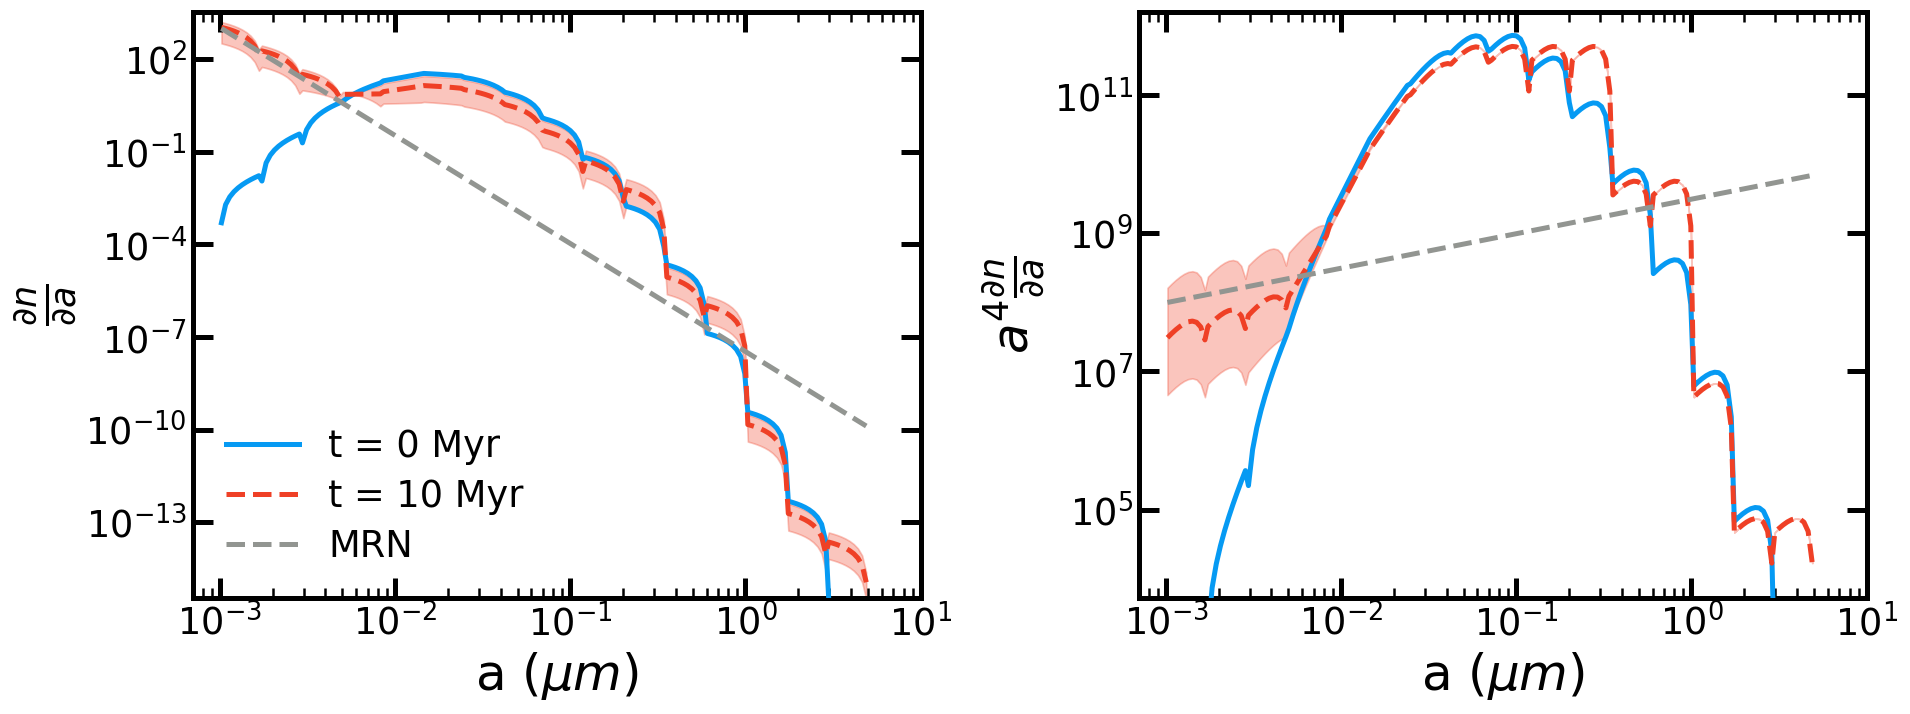

In [279]:
for i,sim_snaps in enumerate(snaps):

    foutname = plot_dir+sim_names[i] + '_coagulation_test.pdf'
    num_snaps = len(sim_snaps)
    fig = Figure(2,ncols=2)
    colors = config.LINE_COLORS[:num_snaps]
    linestyles = config.LINE_STYLES[:num_snaps]
    linewidth = 2*config.BASE_LINEWIDTH
    for j,sp in enumerate(sim_snaps):
        G=sp.loadpart(0)
        time = sp.time*1E3
        spec_ind = 1
        mask = np.argsort(G.get_property('dust_Z')[:,0])[-10:]
        mask = None

        dnda_bin_points, dnda_means, dnda_stds  =  gse.get_grain_size_dist(sp, spec_ind, mask=mask, mass=False,points_per_bin=10)
        dmda_bin_points, dmda_means, dmda_stds =  gse.get_grain_size_dist(sp, spec_ind, mask=mask, mass=True,points_per_bin=10)

        fig.set_axis(0, 'grain_size', 'dn/da',y_lim=[np.power(10,-0.5)*np.min(dnda_means),np.power(10,0.5)*np.max(dnda_means)])
        fig.set_axis(1, 'grain_size', 'dm/da',y_lim=[np.power(10,-0.5)*np.min(dmda_means),np.power(10,0.5)*np.max(dmda_means)])

        fig.plot_line_data(0,dnda_bin_points,dnda_means, color=colors[j],linestyle=linestyles[j],label="t = %.0f Myr"%snap_nums[j])
        fig.plot_shaded_region(0,dnda_bin_points,dnda_stds[:,0],dnda_stds[:,1], color=colors[j])
        fig.plot_line_data(1,dmda_bin_points,dmda_means, color=colors[j],linestyle=linestyles[j])
        fig.plot_shaded_region(1,dmda_bin_points,dmda_stds[:,0],dmda_stds[:,1], color=colors[j])

    # Add a comparison to the MRN size distribution
    C_norm = 1E3/np.power(dnda_bin_points[0],-3.5);
    MRN_dist = C_norm * np.power(dnda_bin_points,-3.5)
    fig.plot_line_data(0,dnda_bin_points,MRN_dist, color='xkcd:grey',linestyle=linestyles[1], label='MRN')

    C_norm = 1E8/np.power(dnda_bin_points[0],0.5);
    MRN_dist = C_norm * np.power(dnda_bin_points,0.5)
    fig.plot_line_data(1,dnda_bin_points,MRN_dist, color='xkcd:grey',linestyle=linestyles[1], label='MRN')

    fig.set_all_legends()
    fig.save(foutname)

# Appendix Plots

## Sub-Resolved Gas Clumping

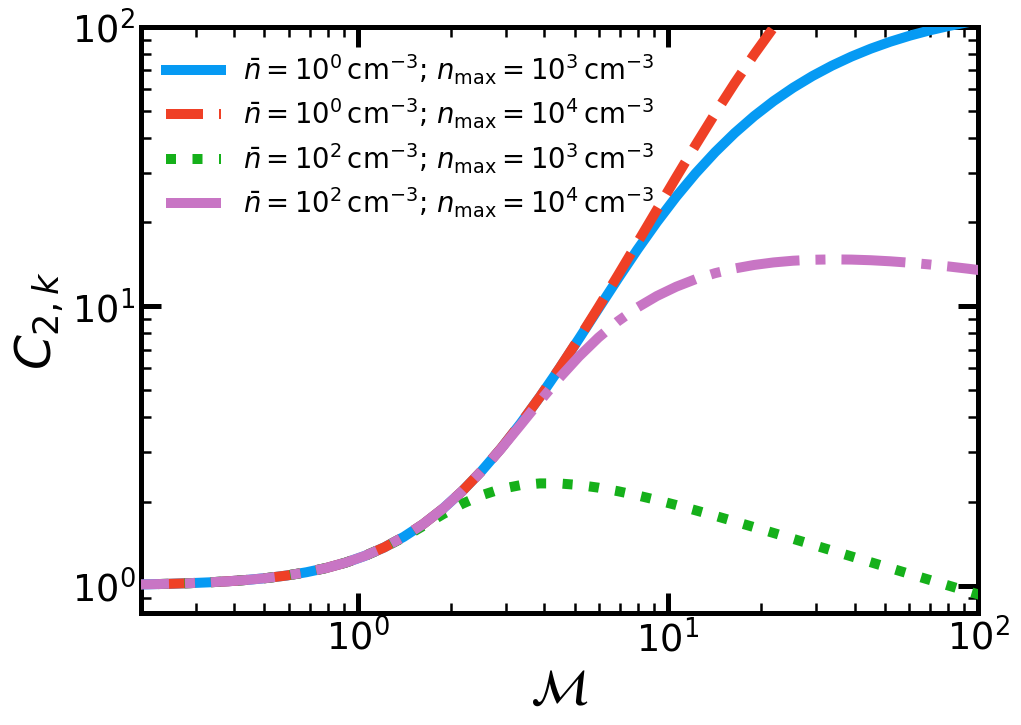

In [52]:
from scipy.special import erfc

foutname = 'clumping_factor.pdf'

M_limits = [0.2,100]
C_limits = [0.8,100]
nmaxs = [1E3,1E4,1E3,1E4]
ns=[1E0,1E0,1E2,1E2]


M = np.logspace(np.log(M_limits[0]),np.log(M_limits[1]),100)
b = 0.5 # ratio of solenoidal to compressive turbulence
sigma = np.sqrt(np.log(1+b*b*M*M))

N = len(nmaxs)

colors = config.LINE_COLORS[:N]
linestyles = config.LINE_STYLES[:N]
linewidth = 2*config.BASE_LINEWIDTH

x_label = r'$\mathcal{M}$'
y_label = r'$C_{2,k}$'
fig = Figure(1)
fig.set_axis(0, 'M', 'clumping_facotr', x_lim=M_limits, x_log=True, x_label=x_label, y_label=y_label, y_lim=C_limits, y_log=True)



for i in range(N):
    nmax=nmaxs[i]
    n=ns[i]
    clumping_factor = np.exp(sigma*sigma)/2 * erfc((3/2*sigma*sigma-np.log(nmax/n)) / (np.sqrt(2)*sigma))
    label = r'$\bar{n}=10^{%i}\,{\rm cm^{-3}}$; $ n_{\rm max}=10^{%i}\,{\rm cm^{-3}}$'%(np.log10(n),np.log10(nmax))
    fig.plot_line_data(0,M,clumping_factor,label=label,linestyle=linestyles[i],color=colors[i], linewidth=linewidth)
    fig.set_all_legends(fontsize=0.75*config.SMALL_FONT)

fig.save(plot_dir+foutname)

## Turbulence Driven Grain Velocity

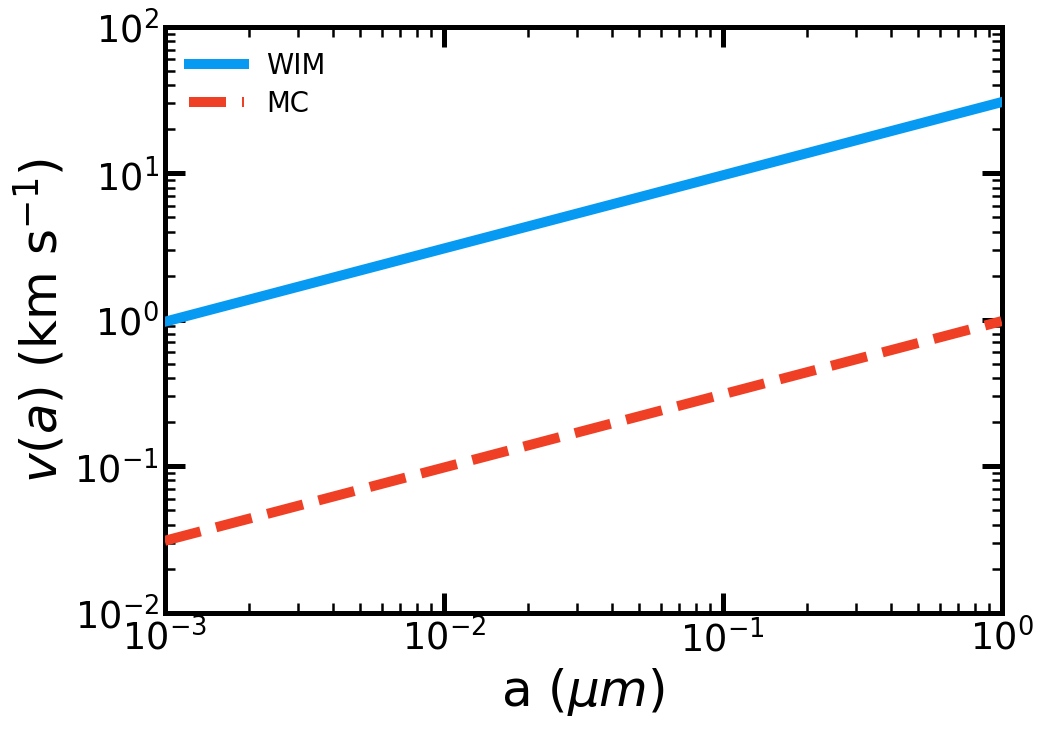

In [115]:
foutname = 'grain_velocity.pdf'

a = np.logspace(-3,0) # micron
Ms = [3.3,3.3] # Mach number
nHs = [0.1,300] # cm^-3
rho_grs = [2.5,2.5] # g cm^-3
Ts = [8000,25]# Kelvin

labels = ['WIM', 'MC']

x_limits = [np.min(a),np.max(a)]
y_limits = [1E-2,1E2]

N=len(Ms)

colors = config.LINE_COLORS[:N]
linestyles = config.LINE_STYLES[:N]
linewidth = 2*config.BASE_LINEWIDTH

x_label = r'a ($\mu m$)'
y_label = r'$v(a)$ (km s$^{-1}$)'
fig = Figure(1)
fig.set_axis(0, 'M', 'clumping_factor', x_lim=x_limits, x_log=True, x_label=x_label, y_label=y_label, y_lim=y_limits, y_log=True)

for i in range(N):
    M=Ms[i]; nH=nHs[i];rho_gr=rho_grs[i];T=Ts[i]
    v_grain = 1.1 * np.power(M,3/2) * np.power(a/0.1,1/2) * np.power(T/1E4,1/4) * np.power(nH/1,-1/4)* np.power(rho_gr/3.5, 1/2.5)
    label = 'Hirashita+19'
    fig.plot_line_data(0,a,v_grain,label=labels[i],linestyle=linestyles[i],color=colors[i], linewidth=linewidth)
    # v_disp = 1.1 * np.power(M,3/2) * np.power(a/0.1,1/2) * np.power(T/1E4,1/4) * np.power(nH/1,-1/4)* np.power(rho_gr/3.5, 1/2.5)
    # label = 'Li+21'
    # fig.plot_line_data(0,a,v_grain,label=label,linestyle=linestyles[i],color=colors[i], linewidth=linewidth)
    fig.set_all_legends(fontsize=0.75*config.SMALL_FONT)

fig.save(plot_dir+foutname)

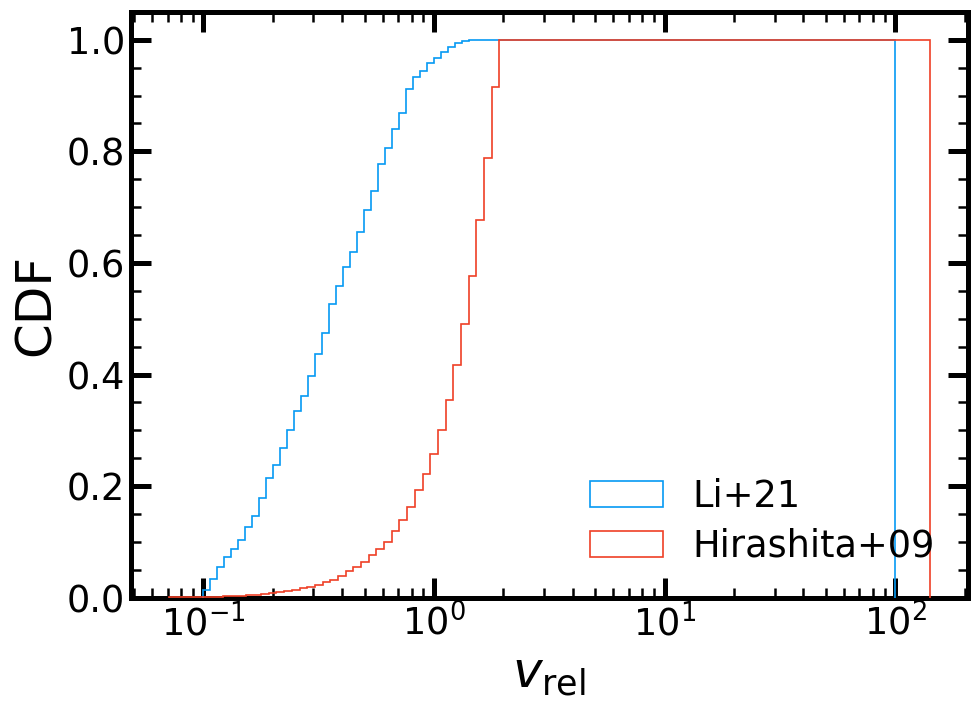

In [111]:
v1 = 1
v2 = 1

N=10000


xlim= [0.1,100]
ylim = [0,1]

colors = config.LINE_COLORS[:2]
linestyles = config.LINE_STYLES[:2]
linewidth = 2*config.BASE_LINEWIDTH

labels = ['Li+21','Hirashita+09']

y_label = 'CDF'
x_label = r'$v_{\rm rel}$'
fig = Figure(1)
fig.set_axis(0, 'vrel', 'prob', x_lim=xlim, x_log=True, x_label=x_label, y_label=y_label, y_lim=ylim, y_log=False)

# Determine relative velocities by taking the difference of x, y, and z components
vrel = np.zeros(N)
for i in range(3):
    v1i=np.random.normal(0,v1*v1/3,1000)
    v2i=np.random.normal(0,v2*v2/3,1000)
    vrel = np.power(v1i-v2i,2)
vrel=np.sqrt(vrel)

#fig.plot_1Dhistogram(0,vrel,bin_log=True)
fig.plot_1Dhistogram(0,vrel,bin_log=True,cumulative=True,label=labels[0])


impact_angle = np.random.uniform(-1,1,N)
vrel = np.sqrt(v1*v1 + v2*v2 - 2*v1*v2*impact_angle)
fig.plot_1Dhistogram(0,vrel,bin_log=True,cumulative=True,label=labels[1])

fig.set_all_legends()

